In [1]:
%matplotlib inline
from math import sqrt
import math
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from random import randint
from scipy.stats import skew
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import NearMiss
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, plot_roc_curve, plot_confusion_matrix, recall_score, precision_score
from sklearn.model_selection import StratifiedKFold,GridSearchCV,RandomizedSearchCV, train_test_split, RepeatedStratifiedKFold#For splitting
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from pandas_profiling import ProfileReport
import sweetviz as sv
import IPython

from catboost import CatBoostClassifier, Pool 
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import optuna  # pip install optuna
from sklearn.metrics import log_loss

import torch
import warnings
warnings.filterwarnings("ignore")

from sklearn.utils.fixes import loguniform

#features_train, features_test, labels_train, labels_test = train_test_split(
#    features, labels, test_size=0.3, random_state=42
#)



import warnings; warnings.simplefilter('ignore')

In [ ]:
newt= pd.read_csv('newt2.csv')
test2 = pd.read_csv('test4.csv')
y1 = pd.read_csv('y1.csv')

In [ ]:
def optimizedata(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
optimizedata(newt)

In [ ]:
optimizedata(test2)

In [ ]:
newt = newt.sample(1000)
test2 = test2.sample(1000)
y1 = y1.sample(1000)

In [7]:
newt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458792 entries, 0 to 458791
Columns: 1765 entries, X1 to user_id
dtypes: float16(81), float32(2), int16(542), int32(117), int8(1023)
memory usage: 1.2 GB


In [8]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24148 entries, 0 to 24147
Columns: 1765 entries, X1 to user_id
dtypes: int16(454), int32(113), int8(1198)
memory usage: 58.9 MB


In [9]:
y1 = y1['label']
y1

0         0
1         0
2         0
3         0
4         0
         ..
458787    0
458788    0
458789    0
458790    0
458791    0
Name: label, Length: 458792, dtype: int64

In [10]:
fcol =np.where((newt.dtypes == np.float32) | (newt.dtypes == np.float16))[0]
fcol

array([  12,   53,   93,  132,  170,  207,  243,  278,  312,  345,  377,
        408,  438,  468,  469,  470,  471,  472,  473,  474,  475,  476,
        477,  478,  479,  480,  481,  482,  483,  484,  485,  486,  487,
        488,  489,  490,  491,  492,  493,  494,  495,  496,  914,  954,
        993, 1031, 1068, 1104, 1139, 1173, 1206, 1238, 1269, 1299, 1329,
       1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340,
       1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351,
       1352, 1353, 1354, 1355, 1356, 1357], dtype=int64)

In [11]:
fcol= newt.columns[fcol]
fcol

Index(['X13', '0.11', '0.51', '0.90', '0.128', '0.165', '0.201', '0.236',
       '0.270', '0.303', '0.335', '0.366', '0.396', '0.426', '0.427', '0.428',
       '0.429', '0.430', '0.431', '0.432', '0.433', '0.434', '0.435', '0.436',
       '0.437', '0.438', '0.439', '0.440', '0.441', '0.442', '0.443', '0.444',
       '0.445', '0.446', '0.447', '0.448', '0.449', '0.450', '0.451', '0.452',
       '0.453', '0.454', '0.872', '0.912', '0.951', '0.989', '0.1026',
       '0.1062', '0.1097', '0.1131', '0.1164', '0.1196', '0.1227', '0.1257',
       '0.1287', '0.1288', '0.1289', '0.1290', '0.1291', '0.1292', '0.1293',
       '0.1294', '0.1295', '0.1296', '0.1297', '0.1298', '0.1299', '0.1300',
       '0.1301', '0.1302', '0.1303', '0.1304', '0.1305', '0.1306', '0.1307',
       '0.1308', '0.1309', '0.1310', '0.1311', '0.1312', '0.1313', '0.1314',
       '0.1315'],
      dtype='object')

In [12]:
fcol= list(fcol)
newt[fcol] = newt[fcol].astype(int)

In [13]:
newt.to_csv('newt3.csv', index=False)

In [13]:
a = newt.columns
a[:43]

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'X25', 'X26', 'X28', 'X31', 'X35', 'X36', 'X37', 'X39',
       'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X47', 'X48', 'X49', 'X50',
       'X51', '0'],
      dtype='object')

In [14]:
categorical_features_indices =np.where((newt.dtypes != np.float32) | (newt.dtypes != np.float16))[0]
categorical_features_indices=np.delete(categorical_features_indices, 0)

categorical_features_indices

array([   1,    2,    3, ..., 1762, 1763, 1764], dtype=int64)

In [30]:
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders import TargetEncoder


In [31]:
def target_encode(cols, train_data, test_data):
    for col in cols:
        target_enc =  CatBoostEncoder()# Instantiate Target Encoder
        train_data[col] = target_enc.fit_transform(train_data[col], y1) # Fit transform the encoder on your data
        test_data[col] =  target_enc.transform(test_data[col]) 

In [26]:
a = newt.columns
a =a[:-1]
a = list(a)

In [53]:
def stratified_cross_val(X, y, test_data, splits=15, seed=42):
    
    skf =  StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)

    scores = [] # a list to store our validation scores

    preds = []  # a list to store our prediction per splits

    model =  CatBoostClassifier(scale_pos_weight=2.111, boosting_type= 'Plain', used_ram_limit= '7GB', eval_metric= 'AUC')# Instantiate your model

    i = 1
    for train, test in skf.split(X, y):
        x_train, x_test, y_train, y_test = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]
        train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)
        test_pool = Pool(x_test, y_test , cat_features=categorical_features_indices)

        model.fit(train_pool, eval_set = test_pool)
        score = f1_score(y_test, model.predict(x_test), average = 'macro')
        pred = model.predict_proba(test_data)[:, 1]
        print(f'Number of splits trained : {i} \t F1 Score:  {score} \t F1 Score:  {pred}')
        scores.append(score)
        preds.append(pred)
        i += 1

    print('The average F1 Score: ', np.mean(scores)) # The mean of our validation scores

    return preds, model

In [ ]:
preds = stratified_cross_val(newt, y1, test2)

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(newt, y1, test_size=0.2, random_state=42) 
cat = CatBoostClassifier(scale_pos_weight = 1.97, eval_metric= 'AUC')#, subsample = 0.1, iterations=200, , eval_metric= 'AUC', bootstrap_type ='MVS', boosting_type= 'Plain', used_ram_limit= '10GB') 
train_pool = Pool(X_train, y_train)#, cat_features=categorical_features_indices)
test_pool = Pool(X_valid, y_valid)# , cat_features=categorical_features_indices)
cat.fit(train_pool)#, eval_set= test_pool)
cat_pred = cat.predict(X_valid)
print("CatBoost accuracy_score on validation set is : ",accuracy_score(y_valid,cat_pred))
print("CatBoost F1 score on validation set is : ",f1_score(y_valid,cat_pred, average = 'macro'))
#0.8585006209853846 2.0
#0.8684401770055199 1.97

Learning rate set to 0.128252
0:	total: 2.27s	remaining: 37m 46s
1:	total: 4.84s	remaining: 40m 15s
2:	total: 7.39s	remaining: 40m 55s
3:	total: 9.65s	remaining: 40m 2s
4:	total: 12.2s	remaining: 40m 29s
5:	total: 14.3s	remaining: 39m 28s
6:	total: 16.9s	remaining: 39m 53s
7:	total: 19s	remaining: 39m 22s
8:	total: 21.9s	remaining: 40m 10s
9:	total: 24.8s	remaining: 40m 50s
10:	total: 26.9s	remaining: 40m 16s
11:	total: 29.1s	remaining: 39m 58s
12:	total: 31.8s	remaining: 40m 12s
13:	total: 34.8s	remaining: 40m 50s
14:	total: 37s	remaining: 40m 28s
15:	total: 39.4s	remaining: 40m 20s
16:	total: 42.1s	remaining: 40m 34s
17:	total: 44.7s	remaining: 40m 39s
18:	total: 47s	remaining: 40m 26s
19:	total: 49.8s	remaining: 40m 40s
20:	total: 52.2s	remaining: 40m 31s
21:	total: 54.5s	remaining: 40m 23s
22:	total: 57.1s	remaining: 40m 25s
23:	total: 59.8s	remaining: 40m 32s
24:	total: 1m 1s	remaining: 40m 8s
25:	total: 1m 3s	remaining: 39m 48s
26:	total: 1m 6s	remaining: 39m 42s
27:	total: 1m 8s

221:	total: 9m 5s	remaining: 31m 50s
222:	total: 9m 7s	remaining: 31m 47s
223:	total: 9m 9s	remaining: 31m 43s
224:	total: 9m 11s	remaining: 31m 39s
225:	total: 9m 14s	remaining: 31m 37s
226:	total: 9m 16s	remaining: 31m 34s
227:	total: 9m 18s	remaining: 31m 29s
228:	total: 9m 20s	remaining: 31m 26s
229:	total: 9m 23s	remaining: 31m 25s
230:	total: 9m 24s	remaining: 31m 20s
231:	total: 9m 27s	remaining: 31m 17s
232:	total: 9m 29s	remaining: 31m 14s
233:	total: 9m 31s	remaining: 31m 11s
234:	total: 9m 34s	remaining: 31m 9s
235:	total: 9m 37s	remaining: 31m 8s
236:	total: 9m 40s	remaining: 31m 8s
237:	total: 9m 42s	remaining: 31m 4s
238:	total: 9m 45s	remaining: 31m 3s
239:	total: 9m 47s	remaining: 30m 59s
240:	total: 9m 49s	remaining: 30m 57s
241:	total: 9m 52s	remaining: 30m 56s
242:	total: 9m 55s	remaining: 30m 54s
243:	total: 9m 58s	remaining: 30m 52s
244:	total: 10m 1s	remaining: 30m 52s
245:	total: 10m 2s	remaining: 30m 47s
246:	total: 10m 5s	remaining: 30m 45s
247:	total: 10m 7s	r

435:	total: 17m 59s	remaining: 23m 16s
436:	total: 18m	remaining: 23m 12s
437:	total: 18m 2s	remaining: 23m 9s
438:	total: 18m 5s	remaining: 23m 6s
439:	total: 18m 7s	remaining: 23m 4s
440:	total: 18m 9s	remaining: 23m 1s
441:	total: 18m 11s	remaining: 22m 57s
442:	total: 18m 13s	remaining: 22m 55s
443:	total: 18m 15s	remaining: 22m 51s
444:	total: 18m 16s	remaining: 22m 47s
445:	total: 18m 19s	remaining: 22m 45s
446:	total: 18m 21s	remaining: 22m 42s
447:	total: 18m 23s	remaining: 22m 40s
448:	total: 18m 25s	remaining: 22m 37s
449:	total: 18m 27s	remaining: 22m 34s
450:	total: 18m 29s	remaining: 22m 30s
451:	total: 18m 31s	remaining: 22m 28s
452:	total: 18m 33s	remaining: 22m 24s
453:	total: 18m 35s	remaining: 22m 21s
454:	total: 18m 36s	remaining: 22m 17s
455:	total: 18m 38s	remaining: 22m 14s
456:	total: 18m 41s	remaining: 22m 12s
457:	total: 18m 43s	remaining: 22m 9s
458:	total: 18m 45s	remaining: 22m 6s
459:	total: 18m 46s	remaining: 22m 2s
460:	total: 18m 48s	remaining: 21m 58s
4

648:	total: 25m 1s	remaining: 13m 32s
649:	total: 25m 3s	remaining: 13m 29s
650:	total: 25m 5s	remaining: 13m 27s
651:	total: 25m 8s	remaining: 13m 24s
652:	total: 25m 9s	remaining: 13m 22s
653:	total: 25m 12s	remaining: 13m 20s
654:	total: 25m 15s	remaining: 13m 18s
655:	total: 25m 17s	remaining: 13m 15s
656:	total: 25m 19s	remaining: 13m 13s
657:	total: 25m 21s	remaining: 13m 10s
658:	total: 25m 24s	remaining: 13m 8s
659:	total: 25m 25s	remaining: 13m 6s
660:	total: 25m 28s	remaining: 13m 3s
661:	total: 25m 30s	remaining: 13m 1s
662:	total: 25m 32s	remaining: 12m 58s
663:	total: 25m 34s	remaining: 12m 56s
664:	total: 25m 36s	remaining: 12m 53s
665:	total: 25m 38s	remaining: 12m 51s
666:	total: 25m 40s	remaining: 12m 48s
667:	total: 25m 42s	remaining: 12m 46s
668:	total: 25m 45s	remaining: 12m 44s
669:	total: 25m 47s	remaining: 12m 42s
670:	total: 25m 48s	remaining: 12m 39s
671:	total: 25m 50s	remaining: 12m 36s
672:	total: 25m 52s	remaining: 12m 34s
673:	total: 25m 54s	remaining: 12m

864:	total: 32m 23s	remaining: 5m 3s
865:	total: 32m 24s	remaining: 5m
866:	total: 32m 26s	remaining: 4m 58s
867:	total: 32m 28s	remaining: 4m 56s
868:	total: 32m 31s	remaining: 4m 54s
869:	total: 32m 33s	remaining: 4m 51s
870:	total: 32m 35s	remaining: 4m 49s
871:	total: 32m 37s	remaining: 4m 47s
872:	total: 32m 39s	remaining: 4m 44s
873:	total: 32m 40s	remaining: 4m 42s
874:	total: 32m 43s	remaining: 4m 40s
875:	total: 32m 45s	remaining: 4m 38s
876:	total: 32m 47s	remaining: 4m 35s
877:	total: 32m 50s	remaining: 4m 33s
878:	total: 32m 52s	remaining: 4m 31s
879:	total: 32m 53s	remaining: 4m 29s
880:	total: 32m 55s	remaining: 4m 26s
881:	total: 32m 57s	remaining: 4m 24s
882:	total: 32m 58s	remaining: 4m 22s
883:	total: 33m 1s	remaining: 4m 19s
884:	total: 33m 4s	remaining: 4m 17s
885:	total: 33m 6s	remaining: 4m 15s
886:	total: 33m 8s	remaining: 4m 13s
887:	total: 33m 10s	remaining: 4m 11s
888:	total: 33m 12s	remaining: 4m 8s
889:	total: 33m 14s	remaining: 4m 6s
890:	total: 33m 15s	rem

In [20]:
cat_viz= cat.get_feature_importance(prettified=True)
cat_viz

,Feature Id,Importances
0,0.1149,6.093142
1,0.1083,5.828851
2,0.1146,5.589992
3,0.1056,4.720388
4,0.1000,4.518940
...,...,...
1760,0.1718,0.000000
1761,0.1719,0.000000
1762,0.1720,0.000000
1763,0.1721,0.000000


,Feature Id,Importances
0,0.1149,6.093142
1,0.1083,5.828851
2,0.1146,5.589992
3,0.1056,4.720388
4,0.1000,4.518940
...,...,...
1760,0.1718,0.000000
1761,0.1719,0.000000
1762,0.1720,0.000000
1763,0.1721,0.000000


<AxesSubplot:xlabel='Importances', ylabel='Feature Id'>

<AxesSubplot:xlabel='Importances', ylabel='Feature Id'>

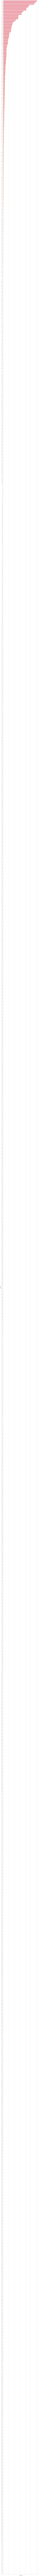

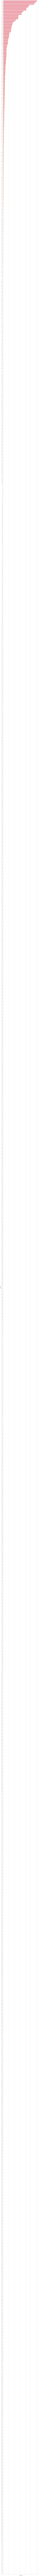

In [21]:
plt.figure(figsize= (12,900))
sns.barplot(x='Importances', y= 'Feature Id', data=cat_viz, label="Feature Importances", orient= 'h')#, color_palette='tab10')
#sns.set_color_palette('hls', 8)

In [23]:
cat_viz1 = cat_viz[cat_viz['Importances']==0]
len(cat_viz1)

1433

1433

In [ ]:
b = ['user_id', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10',
       'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X21', 'X22', 'X23', 'X25', 'X26', 'X28', 'X31', 'X35', 'X36', 'X37',
       'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X47', 'X48', 'X49',
       'X50', 'X51']

In [ ]:
c = list(cat_viz1['Feature Id'])
e = list(set(b+c))
e = sorted(e)
e

In [ ]:
useful_cols = e

In [ ]:
newt1 = newt[useful_cols]
test3 = test2[useful_cols]

In [ ]:
len(newt1.columns)

In [ ]:
len(test3.columns)

In [ ]:
newt1.nunique()

In [ ]:
categorical_features_indices =np.where((newt1.dtypes != np.float32) | (newt1.dtypes != np.float16))[0]
categorical_features_indices=np.delete(categorical_features_indices, -1)

categorical_features_indices

In [ ]:
len(newt1.columns)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(newt1, y1, test_size=0.2, random_state=42) 
cat = CatBoostClassifier(scale_pos_weight =2.111) 
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
cat.fit(train_pool)
cat_pred = cat.predict(X_valid)
print("CatBoost accuracy_score on validation set is : ",accuracy_score(y_valid,cat_pred))
print("CatBoost F1 score on validation set is : ",f1_score(y_valid,cat_pred, average = 'macro'))
#0.8697655984824595
#0.8773670287040178

In [ ]:
newt1.to_csv('newt1.csv', index=False)

In [ ]:
test3.to_csv('test3.csv', index=False)

In [ ]:
if list(newt1.columns) == list(test3.columns):
    print('Yay')
else:
    print('Fuck!!!!!!!!!!')

In [ ]:
y = y1.copy()

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
f
X_new = SelectKBest(chi2, k=200).fit_transform(newt, y)

In [ ]:
X_new =pd.DataFrame(X_new)
X_new

In [ ]:
optimizedata(X_new)

In [ ]:
X_new.info()

In [ ]:
a = pd.DataFrame(X_new.nunique())
a['column'] = list(range(len(a)))
a = a.rename(columns = {0: 'count'})
a = a.sort_values('count' ,ascending = False)
a

In [ ]:
len(X_new)

In [ ]:
categorical_features_indices =np.where((newt1.dtypes != np.float32) | (newt1.dtypes != np.float16))[0]
categorical_features_indices=np.delete(categorical_features_indices, -1)

categorical_features_indices

In [ ]:
#cat = CatBoostClassifier(verbose=False,scale_pos_weight = 1.929,learning_rate= 0.06, n_estimators=3100)#, depth=6)
cat = CatBoostClassifier(scale_pos_weight = 2.111) 
train_pool = Pool(X_new, y1, cat_features=categorical_features_indices)
cat.fit(train_pool)
cat_p = cat.predict(test3)
#highest is 2.01

In [ ]:
submission = pd.DataFrame(columns=['user_id', 'prediction'])
submission.head()

In [ ]:
submission.user_id = test3.user_id
submission.head()

In [ ]:
submission.prediction = cat_p
submission

In [ ]:
submission.to_csv('submissionnew4.csv', index=False)

In [ ]:
a =(16, 30)

In [ ]:
a = list(a)
a

In [ ]:
g = X1[['X21', 'X22']].sum(axis=1)
#g= g.prod(axis = 0)

In [ ]:
g

In [ ]:
math.prod(a)

In [ ]:
comb = combinations(list(range(1, len(X1.columns)+ 1)), 2)

In [ ]:
comb = combinations(X1.columns, 2)

In [ ]:
len(b)

In [ ]:
comb = combinations(X1.columns, 2)
b = X1.copy()
g=0
d=0
for i in list(comb):
    d= list(i)
    g = X1[d].product(axis=1)
    b = pd.concat([b,g], axis=1)
print(len(b))

In [ ]:
prod = pd.DataFrame()
for i in X1.columns:
    for j in X1.columns:
        if i != j:
            for k in list(range(1, 1807)):
                prod[k] = X1[i] * X1[j]

prod

In [ ]:
p = []
for i in list(range(1, len(X1.columns)+ 1)):
    for j in list(range(1, len(X1.columns)+ 1)):
        comb = combinations(list(range(1, len(X1.columns)+ 1)), 2)
        if i != j:
            f= i * j
            p.append(f)
p

In [ ]:
(len(X_train)/(2 *np.bincount(y_train)))

In [ ]:
train1 = train.dropna()
train1 = train1.drop([ 'X38', 'X34', 'X32', 'X24', 'X27', 'X29', 'X30', 'X33', 'X46'], axis=1)

In [ ]:
test2 = test.drop(['X38', 'X34', 'X32', 'X24', 'X27', 'X29', 'X30', 'X33', 'X46'], axis=1)

In [ ]:
y1 = train1.label
X1 = train1.drop(['label'], axis=1)
print(X1.columns, X1.shape)

In [ ]:
#CatBoostClassifier(loss_function='MultiClassOneVsAll', class_weights=class_weights)
X_train, X_valid, y_train, y_valid = train_test_split(X1, y1, test_size=0.2, random_state=42) 
cat = CatBoostClassifier(verbose=False,scale_pos_weight = 1.929,learning_rate= 0.06, n_estimators=3000)
cat.fit(X_train, y_train)
cat_pred = cat.predict(X_valid)
print("CatBoost accuracy_score on validation set is : ",accuracy_score(y_valid,cat_pred))
print("CatBoost F1 score on validation set is : ",f1_score(y_valid,cat_pred, average = 'macro'))
#

In [ ]:
#CatBoostClassifier(loss_function='MultiClassOneVsAll', class_weights=class_weights)
X_train, X_valid, y_train, y_valid = train_test_split(X1, y1, test_size=0.2, random_state=42) 
xg = XGBClassifier(objective = 'binary:logistic', scale_pos_weight = 2.3, learning_rate= 0.07, n_estimators=3000)
xg.fit(X_train, y_train)
xg_pred = xg.predict(X_valid)
print("XGBoost accuracy_score on validation set is : ",accuracy_score(y_valid,xg_pred))
print("XGBoost F1 score on validation set is : ",f1_score(y_valid,xg_pred, average = 'macro'))
#0.8700417748506701

In [ ]:
#CatBoostClassifier(loss_function='MultiClassOneVsAll', class_weights=class_weights)
X_train, X_valid, y_train, y_valid = train_test_split(X1, y1, test_size=0.2, random_state=42) 
#params = {'objective': 'binary','seed': 42, 'learning_rate': 0.03,'n_estimators':3000, 'scale_pos_weight': 2.2}
#params = params
lg = LGBMClassifier(objective = 'binary', scale_pos_weight = 1.9, learning_rate= 0.03, n_estimators=3000)
lg.fit(X_train, y_train)
lg_pred = lg.predict(X_valid)
print("XGBoost accuracy_score on validation set is : ",accuracy_score(y_valid,lg_pred))
print("XGBoost F1 score on validation set is : ",f1_score(y_valid,lg_pred, average = 'macro'))
#0.8673601902612682

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X1, y1, test_size=0.2, random_state=42) 
rf =  RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_valid)
print("RandomForest accuracy_score on validation set is : ",accuracy_score(y_valid,rf_pred))
print("RandomForest F1 score on validation set is : ",f1_score(y_valid,rf_pred, average = 'macro'))

In [ ]:
X1

In [ ]:
X1t = np.array(X1)
y1t = np.array(y1)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X1t, y1t, test_size=0.2, random_state=42) 
a = np.array(X_train)
b = y_train 
tab = TabNetClassifier()
tab.fit(X_train =X_train, y_train=y_train, max_epochs=200, patience = 20 ,weights = {0: 0.5, 1: 1.93}, eval_set = [(X_valid, y_valid)],eval_metric=['balanced_accuracy'])


tab_pred = tab.predict(X_valid)

print("TabNet accuracy_score on validation set is : ",accuracy_score(y_valid,tab_pred))
print("TabNet F1 score on validation set is : ",f1_score(y_valid,tab_pred, average = 'macro'))

In [ ]:
def get_models():
    models = list()
    models.append(('cat', CatBoostClassifier(verbose=False,scale_pos_weight = 1.929,learning_rate= 0.06, n_estimators=3000)))
    models.append(('xg', XGBClassifier(objective = 'binary:logistic', scale_pos_weight = 2.3, learning_rate= 0.07, n_estimators=3000)))
    models.append(('lg', LGBMClassifier(objective = 'binary', scale_pos_weight = 1.9, learning_rate= 0.03, n_estimators=3000)))
    models.append(('rf', RandomForestClassifier(class_weight = {0: 0.5, 1: 1.92}, random_state=42)))
    models.append(('tab', TabNetClassifier(optimizer_fn=torch.optim.Adam, scheduler_params={"step_size":10, "gamma":0.6}, scheduler_fn=torch.optim.lr_scheduler.StepLR)))
    return models

# fit the blending ensemble
def fit_ensemble(models, X_train, X_val, y_train, y_val):
    # fit all models on the training set and predict on hold out set
    meta_X = list()
    for name, model in models:
        if name != 'tab':
            # fit in training set
            model.fit(X_train, y_train)
            # predict on hold out set
            yhat = model.predict(X_val)
            # reshape predictions into a matrix with one column
            yhat = yhat.reshape(len(yhat), 1)
            # store predictions as input for blending
            meta_X.append(yhat)
        else:
            a = np.array(X_train)
            b = np.array(y_train)
            av= np.array(X_val)
            bv= np.array(y_val)
            model.fit(X_train =a, y_train=b, max_epochs=200, weights = {0: 0.5, 1: 1.93}, eval_set = [(av, bv)],eval_metric=['balanced_accuracy', 'auc'])
            yhat = model.predict(av)
            # reshape predictions into a matrix with one column
            yhat = yhat.reshape(len(yhat), 1)
            # store predictions as input for blending
            meta_X.append(yhat)
    # create 2d array from predictions, each set is an input feature
    meta_X = np.hstack(meta_X)
    # define blending model
    blender = CatBoostClassifier(verbose=False,scale_pos_weight = 1.929,learning_rate= 0.06, n_estimators=3000)
    # fit on predictions from base models
    blender.fit(meta_X, y_val)
    return blender

# make a prediction with the blending ensemble
def predict_ensemble(models, blender, X_test):
    # make predictions with base models
    meta_X = list()
    for name, model in models:
        # predict with base model
        if name != 'tab':
            yhat = model.predict(X_test)
            # reshape predictions into a matrix with one column
            yhat = yhat.reshape(len(yhat), 1)
            # store prediction
            meta_X.append(yhat)
        else:
            at = np.array(X_test)
            yhat = model.predict(at)
            # reshape predictions into a matrix with one column
            yhat = yhat.reshape(len(yhat), 1)
            # store prediction
            meta_X.append(yhat)           
    # create 2d array from predictions, each set is an input feature
    meta_X = np.hstack(meta_X)
    # predict
    return blender.predict(meta_X)
 
# define dataset
X = X1
y = y1
# split dataset into train and test sets
# split training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
# summarize data split
print('Train: %s, Val: %s, Test: %s' % (X_train.shape, X_val.shape, X_test.shape))
# create the base models
models = get_models()
# train the blending ensemble
blender = fit_ensemble(models, X_train, X_val, y_train, y_val)
# make predictions on test set
yhat = predict_ensemble(models, blender, test2)
# evaluate predictions
#score = f1_score(y_test, yhat, average = 'macro')
#print('Blending score: %.3f' % (score*100))

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X1, y1, test_size=0.2, random_state=42) 

clf1 =CatBoostClassifier(verbose=False,scale_pos_weight = 1.929,learning_rate= 0.06, n_estimators=3000)
clf2 = XGBClassifier(objective = 'binary:logistic', scale_pos_weight = 2.3, learning_rate= 0.07, n_estimators=3000)
clf3 = LGBMClassifier(objective = 'binary', scale_pos_weight = 1.9, learning_rate= 0.03, n_estimators=3000)
clf4 = RandomForestClassifier(class_weight = {0: 0.5, 1: 1.92}, random_state=42)
#clf5 = TabNetClassifier(optimizer_fn=torch.optim.Adam, scheduler_params={"step_size":10, "gamma":0.6}, scheduler_fn=torch.optim.lr_scheduler.StepLR)


eclf2 = StackingClassifier(estimators=[
        ('cat', clf1), ('xg', clf2), ('lg', clf3), ('rf', clf4)],final_estimator= CatBoostClassifier(verbose=False,scale_pos_weight = 1.929,learning_rate= 0.06, n_estimators=3000),
                           stack_
         )
eclf2 = eclf2.fit(X_train, y_train)
eclf2_pred = eclf2.predict(X_valid)

print("StackingClassifier accuracy_score on validation set is : ",accuracy_score(y_valid,eclf2_pred))
print("StackingClassifier F1 score on validation set is : ",f1_score(y_valid,eclf1_pred, average = 'macro'))

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X1t, y1t, test_size=0.2, random_state=42) 

clf1 =CatBoostClassifier(verbose=False,scale_pos_weight = 1.929,learning_rate= 0.06, n_estimators=3000)
clf2 = XGBClassifier(objective = 'binary:logistic', scale_pos_weight = 2.3, learning_rate= 0.07, n_estimators=3000)
clf3 = LGBMClassifier(objective = 'binary', scale_pos_weight = 1.9, learning_rate= 0.03, n_estimators=3000)
clf4 = RandomForestClassifier(class_weight = {0: 0.5, 1: 1.92}, random_state=42)
#clf5 = TabNetClassifier(optimizer_fn=torch.optim.Adam, scheduler_params={"step_size":10, "gamma":0.6}, scheduler_fn=torch.optim.lr_scheduler.StepLR)
#, weights = [0.5, 1.92]
eclf2 = VotingClassifier(estimators=[
        ('cat', clf1), ('xg', clf2), ('lg', clf3), ('rf', clf4)],
         voting='soft', n_job=-1)
eclf2 = eclf2.fit(X_train, y_train)
eclf2_pred = eclf2.predict(X_valid)

print("VotingClassifier accuracy_score on validation set is : ",accuracy_score(y_valid,eclf2_pred))
print("VotingClassifier F1 score on validation set is : ",f1_score(y_valid,eclf1_pred, average = 'macro'))

In [ ]:
xg = XGBClassifier(objective = 'binary:logistic', scale_pos_weight = 2.3, learning_rate= 0.07, n_estimators=3000)
xg = xg.fit(X1,y1)
cat_p = xg.predict(test2)

In [ ]:
cat = CatBoostClassifier(verbose=False,scale_pos_weight = 1.929,learning_rate= 0.06, n_estimators=3000)#, depth=6)
cat = cat.fit(X1, y1)
cat_p = cat.predict(test2)

In [ ]:
#cat = CatBoostClassifier(verbose=False,scale_pos_weight = 1.929,learning_rate= 0.06, n_estimators=3100)#, depth=6)
cat = CatBoostClassifier(scale_pos_weight = 2.111) 
train_pool = Pool(newt1, y1, cat_features=categorical_features_indices)
cat.fit(train_pool)
cat_p = cat.predict(test2)
#highest is 2.01

In [ ]:
submission = pd.DataFrame(columns=['user_id', 'prediction'])
submission.head()

In [ ]:
submission.user_id = test.user_id
submission.head()

In [ ]:
submission.prediction = cat_p
submission

In [ ]:
submission.to_csv('submissionnew.csv', index=False)